In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocessing

In [2]:
dataset=pd.read_csv('nuovo_dataset_totale.csv')
dataset=dataset.drop(['id'], axis=1)
# Assuming df is your original DataFrame with a column named "genre"

# Define a function to assign class labels
def assign_class(genre):
    if genre in ['Hip hop', 'house', 'Black metal', 'techno', 'electronic', 
                 'Hard rock', 'heavy-metal', 'metal', 'rock', 'reggaeton']:
        return 1  # Agitato
    elif genre in ['ambient', 'sleep', 'study', 'sad', 'romance', 'chill', 
                   'classical', 'piano', 'opera', 'acoustic']:
        return 0  # Lento
    else:
        return None  # Unknown or other genre

# Add a new column "class" to the original DataFrame
dataset['class'] = dataset['genre'].apply(assign_class)

# Drop rows with unknown or other genres
dataset.dropna(subset=['class'], inplace=True)

# Convert the "class" column to integer type
dataset['class'] = dataset['class'].astype(int)

y=dataset["class"]

# Funzione per trasformare le stringhe in liste di float
def trasforma_in_lista(lst_str):
    # Rimuovi i caratteri '[' e ']' e splitta la stringa
    lst_str = lst_str.strip('][').split(', ')
    # Utilizza eval per valutare la lista di stringhe e convertirla in una lista di float
    return [float(x) for x in lst_str]

# Applica la funzione a ciascun valore nella colonna
dataset['popularity_artist'] = dataset['popularity_artist'].apply(trasforma_in_lista)

# Calcola la media di ciascuna lista
dataset['popularity_artist'] = round(dataset['popularity_artist'].apply(np.mean),2)

X=dataset.drop(['class', 'name', 'explicit', 'artists', 'disc_number','album_type', 'album_release_date', 'album_release_date_precision',
       'album_total_tracks', 'album_name', 'mode_confidence', 'genre'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=72)

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# Logistic regression

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Optimization algorithm
                                                #in svm abbiamo tenuto linear
    'max_iter': [1000,2000],
    'tol': [0.001, 0.1, 0.01],
    'dual': [True, False]
}

# Create logistic regression classifier
logistic_regression = LogisticRegression()

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best Parameters: {'C': 0.1, 'dual': False, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


In [ ]:
print("Best Parameters:", grid_search.best_score_)

Best Parameters: 0.905615470435106


In [ ]:
# Create logistic regression classifier
logistic_regression = LogisticRegression(**best_params)
logistic_regression.fit(X_train_norm, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear',
                   tol=0.001)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9033313503866746
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1986
           1       0.86      0.91      0.89      1376

    accuracy                           0.90      3362
   macro avg       0.90      0.90      0.90      3362
weighted avg       0.91      0.90      0.90      3362

Confusion Matrix:
 [[1783  203]
 [ 122 1254]]


c:\Users\corra\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


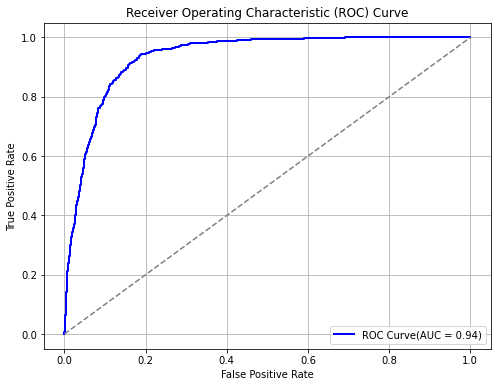

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Obtain predicted probabilities for the positive class (class 1)
y_prob = grid_search.best_estimator_.predict_proba(X_test_norm)[:, 1]

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve(AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# MultiLayerPerceptron (=Neural Network 1+ hid.layers)

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],  # Various hidden layer sizes
    'activation': ['logistic', 'tanh', 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers for optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'learning_rate': ['constant', 'adaptive'],
    'momentum': [0.1, 0.01, 0.001],
    'n_iter_no_change': [20, 30],
    'early_stopping': [True] # Learning rate schedule
}

# Create MLP classifier
mlp_classifier = MLPClassifier()

# Perform grid search with cross-validation (cv=5)
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", best_params)